# Metis Data Science Bootcamp
## San Francisco, Winter 2020
### Project 4: Election Reporting Sentiment Analysis

In [1]:
import sys
import re
import os.path
import requests
import time
import pandas as pd

from os import path

from pymongo import MongoClient

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

from spacy.lang.en import English

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


In [4]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']

In [5]:
db_news_content = db_news['news_content']
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})

In [6]:
print(len(list(cursor)))

3795


In [7]:
import re
import string
import datetime as dt

In [8]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation+'\\'), ' ', x.lower())

In [10]:
#db_news.news_search.update_many({}, { '$set' : { "scraped": 'y'}})

## Sentiment Analysis

In [10]:
polarity_list = []
subjectivity_list = []
date_list = []
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'sentiment':1, 'pub_date':1})
for article in list(cursor) :
    sentiment = article['sentiment']
    polarity_list.append(sentiment[0])
    subjectivity_list.append(sentiment[1])
    date_list.append(dt.datetime.strptime(article['pub_date'].split('T')[0], '%Y-%m-%d'))
    
max(polarity_list), min(polarity_list), max(subjectivity_list), min(subjectivity_list)

(1.0, -0.6999999999999998, 1.0, 0.0)

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


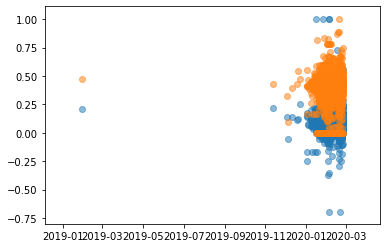

In [11]:
import matplotlib.pyplot as plt

plt.scatter(date_list, polarity_list, alpha=0.5)
plt.scatter(date_list, subjectivity_list, alpha=0.5)

Look into Text Blob sentiment analysis

In [12]:
from textblob import TextBlob
polarity_list = []
subjectivity_list = []

# build our corpus
corpus = []
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'sentiment' : 1 })
for article in list(cursor) :
    polarity_list.append(article['sentiment'][0])
    subjectivity_list.append(article['sentiment'][1])

(array([1.560e+02, 3.500e+01, 1.750e+02, 1.157e+03, 1.858e+03, 3.670e+02,
        3.000e+01, 1.000e+01, 6.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

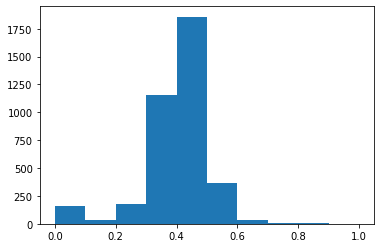

In [13]:
plt.hist(subjectivity_list)

(array([2.000e+00, 1.000e+00, 7.000e+00, 8.900e+01, 2.675e+03, 9.400e+02,
        7.200e+01, 4.000e+00, 1.000e+00, 4.000e+00]),
 array([-0.7 , -0.53, -0.36, -0.19, -0.02,  0.15,  0.32,  0.49,  0.66,
         0.83,  1.  ]),
 <a list of 10 Patch objects>)

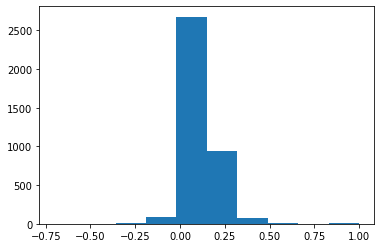

In [14]:
plt.hist(polarity_list)

In [ ]:
db_news_sources = db_news['pub_locations']

In [16]:
lat_list = []
lng_list = []
publishers = []
sentiment_polarity_list = []
sentiment_subjectivity_list = []
sent_polarity_aves = []
sent_subjectivity_aves = []
sent_colors = []

cursor = db_news_sources.find({}, {'_id':1, 'name':1, 'address':1, 'zip':1, 'googID': 1, 'lat':1, 'lng':1})
pub_list = list(cursor)

for pub in pub_list :
    lat_list.append(pub['lat'])
    lng_list.append(pub['lng'])
    publishers.append(pub['name'])
    article_cur = db_news_content.find({'base_url':pub['name']}, {'_id':0, 'sentiment':1})
    for article in list(article_cur) :
        sentiment_polarity_list = article['sentiment'][0]
        sentiment_subjectivity_list = article['sentiment'][1]
    sent_polarity_aves.append(np.mean(sentiment_polarity_list))
    sent_subjectivity_aves.append(np.mean(sentiment_subjectivity_list))

polar_color_pick = lambda y : 'red' if y < -0.5 else ('yellow' if y < 0.0 else ('green' if y > 0.5 else ( 'blue' if y > 0 else  'black')))
sent_colors = [polar_color_pick(z) for z in sent_polarity_aves]

In [17]:
import folium
from folium.plugins import HeatMap
import numpy as np

def generateBaseMap(default_location=[np.mean(lat_list), np.mean(lng_list)], default_zoom_start=4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

basemap = generateBaseMap()

# Visualize physical subway locations
for lat,lon,publisher,color in zip(lat_list,lng_list,publishers, sent_colors):
     folium.CircleMarker([lat, lon],
                            popup=publisher,
                            color=color,
                            fill=True,
                            fill_opacity=0.7,
                            radius=4,
                           ).add_to(basemap)
basemap

